In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [2]:
def drop_outliers_zscore(df, cols, thresh):
    drop_idx = []
    for col in cols:
        drop_idx.extend(df[np.abs(stats.zscore(df[col])) >= thresh].index)
    return df.drop(set(drop_idx))

def outliers_IQR(df, var):
    q1=df[var].quantile(0.25)
    q3=df[var].quantile(0.75)
    IQR=q3-q1
    outliers = df[((df[var]<(q1-1.5*IQR)) | (df[var]>(q3+1.5*IQR)))]
    return outliers[var].describe()
#     not_outliers = df[~((df[var]<(q1-1.5*IQR)) | (df[var]>(q3+1.5*IQR)))]
#     outliers_dropped = outliers.dropna().reset_index()
#     return not_outliers

def compute_vif(df, considered_features):    
    X = df[considered_features]
    X['intercept'] = 1

    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [3]:
day_names = [         
        'Monday',         
        'Tuesday',         
        'Wednesday',         
        'Thursday',         
        'Friday',         
        'Saturday',
        'Sunday',    
        ]
seasons = {0:'Spring', 1:'Summer', 2:'Fall',3:'Winter'}
cols = ['cnt', 't1', 't2', 'hum', 'wind_speed']

In [4]:
data = pd.read_csv('london_merged.csv')
display(data.head())
data.info()

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season
0,4/1/2015 0:00,182,3.0,2.0,93.0,6.0,0,1.0,3
1,4/1/2015 1:00,138,3.0,2.5,93.0,5.0,0,1.0,3
2,4/1/2015 2:00,134,2.5,2.5,96.5,0.0,0,1.0,3
3,4/1/2015 3:00,72,2.0,2.0,100.0,0.0,0,1.0,3
4,4/1/2015 4:00,47,2.0,0.0,93.0,6.5,0,1.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   17414 non-null  object 
 1   cnt         17414 non-null  int64  
 2   t1          17414 non-null  float64
 3   t2          17414 non-null  float64
 4   hum         17414 non-null  float64
 5   wind_speed  17414 non-null  float64
 6   is_holiday  17414 non-null  int64  
 7   is_weekend  17413 non-null  float64
 8   season      17414 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 1.2+ MB


# Exploratory Data Analysis

In [5]:
data['ts'] = pd.to_datetime(data.timestamp)
data['time'] = data.ts.apply(lambda x: x.time().strftime("%H:%M"))
data['date'] = data.ts.apply(lambda x: x.date())
data['month'] = data.ts.apply(lambda x: x.month)
data['year'] = data.ts.apply(lambda x: x.year)
data['season_str'] = data.season.apply(lambda x: seasons[x])
data['day'] = data.ts.dt.day_name()
data['hour'] = data['time'].apply(lambda x: int(x[:2]))
data.dropna(inplace=True)
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,ts,time,date,month,year,season_str,day,hour
0,4/1/2015 0:00,182,3.0,2.0,93.0,6.0,0,1.0,3,2015-04-01 00:00:00,00:00,2015-04-01,4,2015,Winter,Wednesday,0
1,4/1/2015 1:00,138,3.0,2.5,93.0,5.0,0,1.0,3,2015-04-01 01:00:00,01:00,2015-04-01,4,2015,Winter,Wednesday,1
2,4/1/2015 2:00,134,2.5,2.5,96.5,0.0,0,1.0,3,2015-04-01 02:00:00,02:00,2015-04-01,4,2015,Winter,Wednesday,2
3,4/1/2015 3:00,72,2.0,2.0,100.0,0.0,0,1.0,3,2015-04-01 03:00:00,03:00,2015-04-01,4,2015,Winter,Wednesday,3
4,4/1/2015 4:00,47,2.0,0.0,93.0,6.5,0,1.0,3,2015-04-01 04:00:00,04:00,2015-04-01,4,2015,Winter,Wednesday,4


In [6]:
data[cols].describe()

,cnt,t1,t2,hum,wind_speed
count,17413.000000,17413.000000,17413.000000,17413.000000,17413.000000
mean,1143.147878,12.467831,11.520521,72.368446,15.912915
std,1085.122073,5.571872,6.615204,15.464679,7.894773
min,0.000000,-1.500000,-6.000000,20.500000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000
75%,1672.000000,16.000000,16.000000,83.000000,20.500000
max,7860.000000,34.000000,34.000000,845.000000,56.500000


In [7]:
data.groupby('season').cnt.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
0,4394.0,1103.831589,1038.999553,0.0,234.0,823.0,1624.00,5322.0
1,4386.0,1464.722070,1250.789661,12.0,372.0,1215.0,2207.75,7860.0
2,4303.0,1178.954218,1095.654318,9.0,296.0,898.0,1716.50,5422.0
3,4330.0,821.729099,807.439902,10.0,184.0,632.0,1133.75,4415.0


/var/folders/3h/djzfk7rx2lz1dhv708z72klr0000gn/T/ipykernel_91358/1088889129.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data[cols].hist(ax=ax, density=True, bins=25)


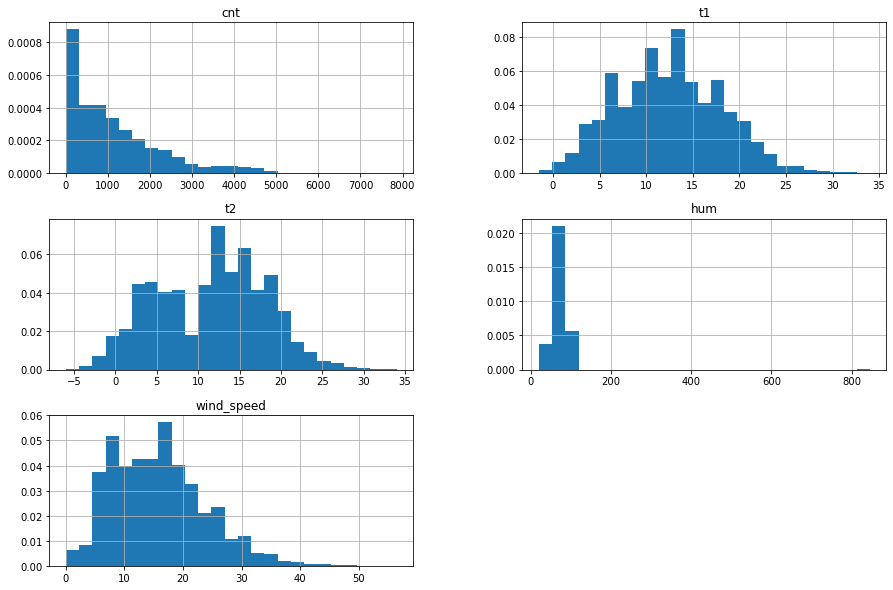

In [8]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
data[cols].hist(ax=ax, density=True, bins=25)
# plt.show()
plt.savefig('figures/raw_data_distribution.png')


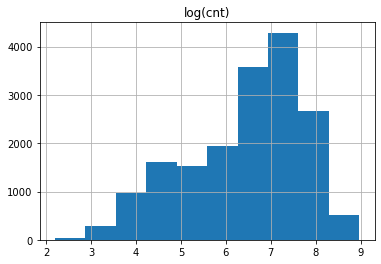

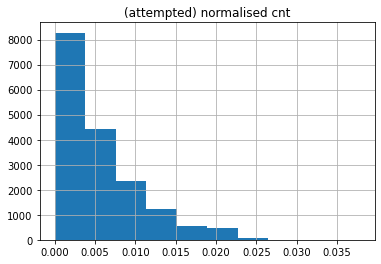

In [9]:
data[data['cnt'] == 0] # exclude cnt == 0 (1 data point) to try to normalise series
pd.Series(np.log(data[data['cnt']!=0]['cnt'])).hist()
plt.title('log(cnt)')
plt.show()

normalized_arr = pd.Series(preprocessing.normalize([data.cnt])[0])
normalized_arr.hist()
plt.title('(attempted) normalised cnt')
plt.show()

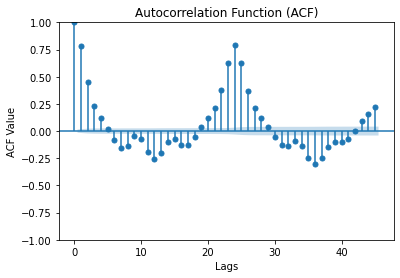

In [10]:
plot_acf(data['cnt'], lags=45)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.savefig('figures/acf.png')
plt.show()

In [11]:
adftest = adfuller(data['cnt'], autolag='AIC', regression='ct')
print("ADF-Statistic:", round(adftest[0],2))
print("P-Value:", round(adftest[1],2))
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
# series is non-stationary 

ADF-Statistic: -9.92
P-Value: 0.0
Number of lags: 41
Number of observations: 17371
Critical Values: {'1%': -3.9592912559418125, '5%': -3.4107427730313553, '10%': -3.1271988587891006}


In [12]:
df = drop_outliers_zscore(data, cols, 3)
df['hum_bins'] = pd.cut(df['hum'], bins=10, retbins=False, precision=2)
df['t1_bins'] = pd.cut(df['t1'], bins=10, retbins=False, precision=2)
df['t2_bins'] = pd.cut(df['t2'], bins=10, retbins=False, precision=2)
df.dropna(inplace=True)
# df.to_csv('bike_data_outliers_excluded.csv')

In [13]:
df.groupby(by=['hum_bins','t2_bins'])['cnt'].describe()

count         mean          std     min      25%  \
hum_bins      t2_bins                                                           
(25.93, 33.4] (8.2, 11.75]     1.0   626.000000          NaN   626.0   626.00   
              (11.75, 15.3]   13.0  1722.153846   795.683338   914.0  1253.00   
              (15.3, 18.85]    8.0  2336.500000   909.426978  1464.0  1562.75   
              (18.85, 22.4]   17.0  2829.000000   939.875524  1355.0  1785.00   
              (22.4, 25.95]   16.0  2759.062500   908.122493  1325.0  2038.00   
...                            ...          ...          ...     ...      ...   
(92.6, 100.0] (4.65, 8.2]    242.0   641.859504   841.792154    17.0   108.50   
              (8.2, 11.75]   176.0   617.573864   760.189777    20.0   112.00   
              (11.75, 15.3]  194.0   523.731959   667.755245    13.0   101.25   
              (15.3, 18.85]   45.0   545.177778   788.241694    33.0    98.00   
              (18.85, 22.4]   17.0   644.352941  1065.096823    12.0    91.00   

                                50%      75%     max  
hum_bins      t2_bins                                 
(25.93, 33.4] (8.2, 11.75]    626.0   626.00   626.0  
              (11.75, 15.3]  1303.0  2010.00  3794.0  
              (15.3, 18.85]  2244.5  2742.25  4133.0  
              (18.85, 22.4]  3027.0  3491.00  4322.0  
              (22.4, 25.95]  2853.0  3487.75  3881.0  
...                             ...      ...     ...  
(92.6, 100.0] (4.65, 8.2]     294.5   755.00  4198.0  
              (8.2, 11.75]    306.5   778.75  4109.0  
              (11.75, 15.3]   265.5   687.00  4162.0  
              (15.3, 18.85]   242.0   644.00  4325.0  
              (18.85, 22.4]   143.0   562.00  3528.0  

[84 rows x 8 columns]

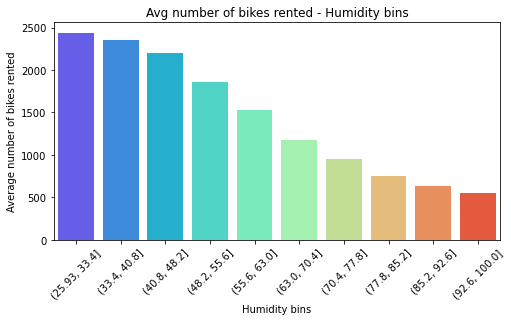

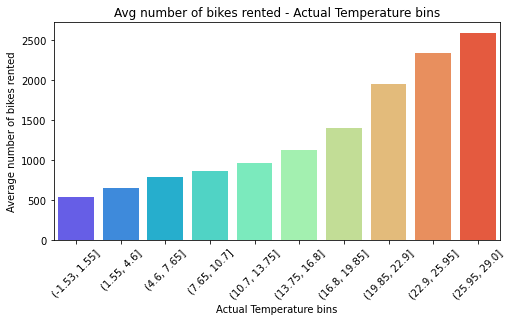

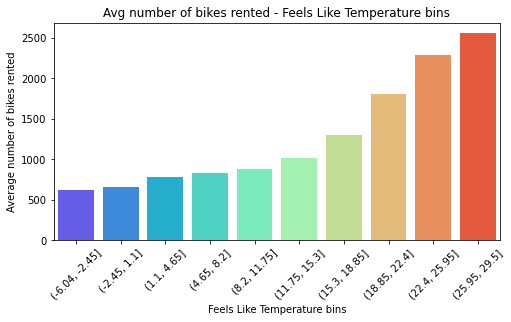

In [14]:
bin_dict = {'hum_bins': 'Humidity bins', 't1_bins': 'Actual Temperature bins', 't2_bins': 'Feels Like Temperature bins'}
for i in bin_dict:
    plt.figure(figsize=(8,4))
    sns.barplot(x=i,y='cnt', data=df[df['year']<2017],palette='rainbow', ci=None)
#     plt.legend(loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel(f'{bin_dict[i]}')
    plt.ylabel('Average number of bikes rented')
    plt.title(f'Avg number of bikes rented - {bin_dict[i]}')
    plt.xticks(rotation=45)
    plt.savefig(f'figures/avg_bike_rental_per_{i}.png',bbox_inches='tight')
    plt.show()

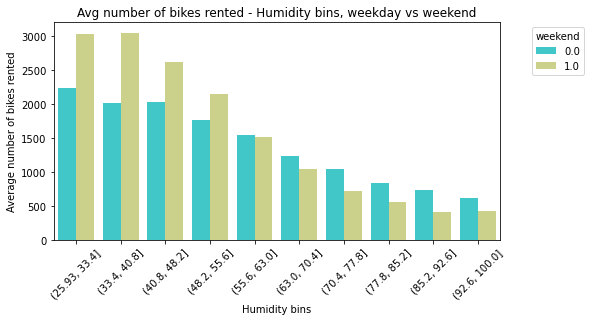

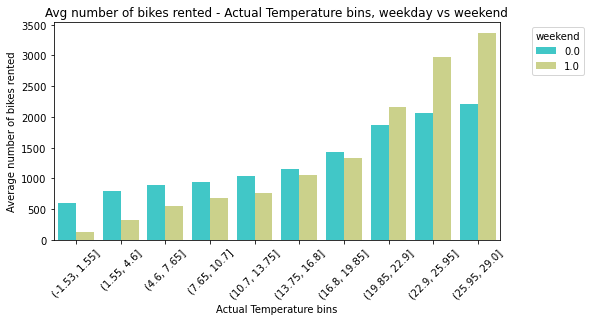

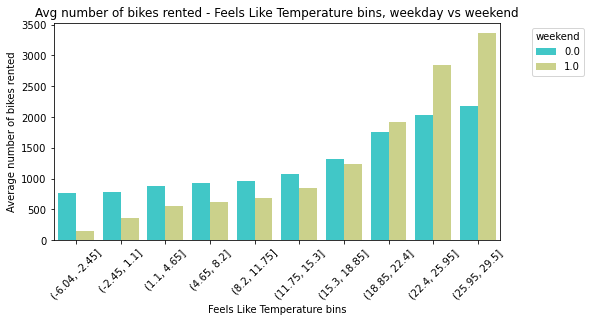

In [15]:
bin_dict = {'hum_bins': 'Humidity bins', 't1_bins': 'Actual Temperature bins', 't2_bins': 'Feels Like Temperature bins'}
for i in bin_dict:
    plt.figure(figsize=(8,4))
    sns.barplot(x=i,y='cnt',hue='is_weekend', data=df[df['year']<2017],palette='rainbow', ci=None)
    plt.legend(loc='upper right',bbox_to_anchor=(1.2,1),title='weekend')
    plt.xlabel(f'{bin_dict[i]}')
    plt.ylabel('Average number of bikes rented')
    plt.title(f'Avg number of bikes rented - {bin_dict[i]}, weekday vs weekend')
    plt.savefig(f'figures/avg_bike_rental_per_{i}_weekend.png',bbox_inches='tight')
    plt.xticks(rotation=45)

    plt.show()

In [16]:
df.groupby(['t2_bins','year']).cnt.describe()

count         mean          std     min      25%  \
t2_bins        year                                                      
(-6.04, -2.45] 2015    66.0   647.696970  1000.690254    25.0    73.25   
               2016    30.0   569.833333  1045.797867    17.0    34.50   
               2017     7.0   701.571429  1092.820641    10.0    36.50   
(-2.45, 1.1]   2015   492.0   652.587398   756.315389    16.0   102.00   
               2016   524.0   652.162214   929.685141    12.0    73.00   
               2017    23.0   477.000000   518.041767    18.0   125.00   
(1.1, 4.65]    2015   834.0   764.708633   820.715559    14.0   117.00   
               2016  1295.0   789.247876   821.157405     9.0   151.00   
               2017    30.0   577.433333   631.134648    35.0   123.25   
(4.65, 8.2]    2015  1281.0   794.750195   835.633400    14.0   147.00   
               2016  1470.0   864.225850   858.033877    11.0   172.00   
               2017    12.0   372.916667   310.205931    77.0   124.50   
(8.2, 11.75]   2015   845.0   851.126627   872.550881     0.0   153.00   
               2016   845.0   916.431953   837.856484    20.0   202.00   
(11.75, 15.3]  2015  2451.0   987.178295   900.813921    14.0   269.00   
               2016  1660.0  1050.065060   943.617136    13.0   265.75   
(15.3, 18.85]  2015  1503.0  1338.644045  1027.262622    30.0   486.00   
               2016  1327.0  1245.527506  1023.741559    33.0   347.50   
(18.85, 22.4]  2015   769.0  1948.671001  1027.460385    71.0  1237.00   
               2016   957.0  1690.362591  1056.263830    12.0   932.00   
(22.4, 25.95]  2015   183.0  2419.967213   879.522828    48.0  1679.00   
               2016   274.0  2195.948905   821.599484   158.0  1648.50   
(25.95, 29.5]  2015    27.0  2660.481481   838.750690   949.0  1916.50   
               2016    86.0  2526.872093   891.567566  1153.0  1780.00   

                        50%      75%     max  
t2_bins        year                           
(-6.04, -2.45] 2015   158.0   461.75  3700.0  
               2016    93.5   547.75  4109.0  
               2017    83.0   920.50  2904.0  
(-2.45, 1.1]   2015   389.5   827.25  3919.0  
               2016   255.0   743.75  4188.0  
               2017   334.0   648.50  2220.0  
(1.1, 4.65]    2015   502.5  1067.50  4053.0  
               2016   544.0  1068.00  4386.0  
               2017   253.0   947.75  2742.0  
(4.65, 8.2]    2015   557.0  1086.00  4283.0  
               2016   629.0  1232.75  4298.0  
               2017   248.5   537.25   933.0  
(8.2, 11.75]   2015   578.0  1192.00  4379.0  
               2016   744.0  1259.00  4358.0  
(11.75, 15.3]  2015   745.0  1350.50  4395.0  
               2016   811.5  1444.50  4356.0  
(15.3, 18.85]  2015  1172.0  1957.00  4393.0  
               2016  1043.0  1882.50  4348.0  
(18.85, 22.4]  2015  1739.0  2519.00  4384.0  
               2016  1586.0  2382.00  4391.0  
(22.4, 25.95]  2015  2321.0  3171.50  4328.0  
               2016  1938.5  2685.50  4319.0  
(25.95, 29.5]  2015  2720.0  3315.00  3999.0  
               2016  2472.0  3261.75  4377.0

/Users/antrierakleous/opt/anaconda3/envs/pet/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


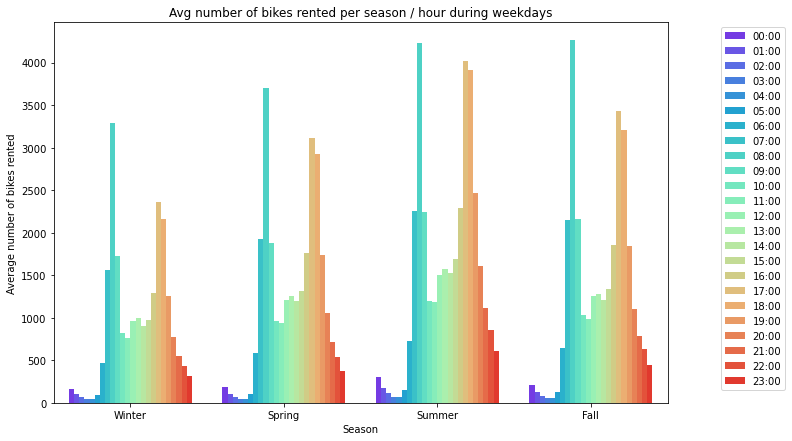

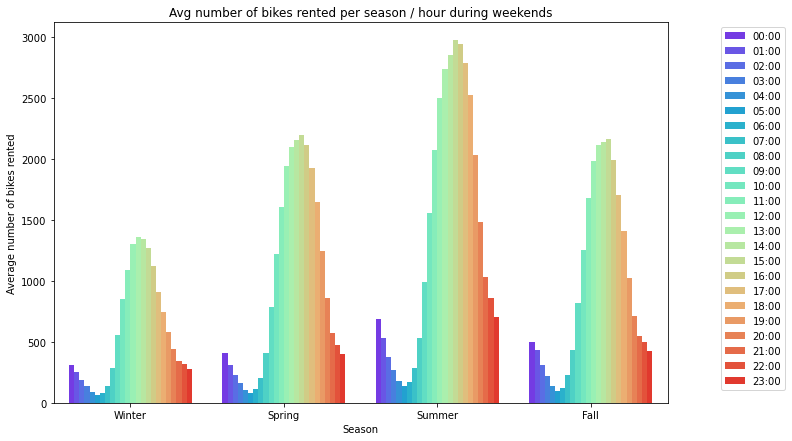

In [17]:
plt.figure(figsize=(11,7))
sns.barplot('season_str','cnt',hue='time', data=data[(data['year']<2017)&(data['is_weekend']==0)],palette='rainbow', ci=None)
plt.legend(loc='upper right',bbox_to_anchor=(1.2,1))
plt.xlabel('Season')
plt.ylabel('Average number of bikes rented')
plt.title('Avg number of bikes rented per season / hour during weekdays')
plt.savefig('figures/avg_bikes_rented_weekdays_bar.png',bbox_inches='tight')

plt.show()
# plt.tight_layout()

plt.figure(figsize=(11,7))
sns.barplot(x='season_str',y='cnt',hue='time', data=data[(data['year']<2017)&(data['is_weekend']==1)],palette='rainbow', ci=None)
plt.legend(loc='upper right',bbox_to_anchor=(1.2,1))
plt.xlabel('Season')
plt.ylabel('Average number of bikes rented')
plt.title('Avg number of bikes rented per season / hour during weekends')
plt.savefig('figures/avg_bikes_rented_weekends_bar.png',bbox_inches='tight')
plt.show()

In [18]:
# peak hours 7,8,9 16-20 weekdays, 


/var/folders/3h/djzfk7rx2lz1dhv708z72klr0000gn/T/ipykernel_91358/553348891.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df[cols].hist(ax=ax, density=True,bins=25)


,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,month,year,hour
count,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000,16991.000000
mean,1087.612148,12.340229,11.383075,72.614428,15.730392,0.022012,0.290154,1.496145,6.520629,2015.506857,11.500088
std,997.380452,5.474932,6.532298,14.126666,7.594479,0.146726,0.453846,1.123286,3.460434,0.508373,6.958372
min,0.000000,-1.500000,-6.000000,26.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,0.000000
25%,244.000000,8.000000,6.000000,63.500000,10.000000,0.000000,0.000000,0.000000,4.000000,2015.000000,5.000000
50%,823.000000,12.000000,12.000000,75.000000,15.000000,0.000000,0.000000,1.000000,7.000000,2016.000000,12.000000
75%,1616.000000,16.000000,16.000000,83.000000,20.500000,0.000000,1.000000,3.000000,10.000000,2016.000000,18.000000
max,4395.000000,29.000000,29.500000,100.000000,39.500000,1.000000,1.000000,3.000000,12.000000,2017.000000,23.000000


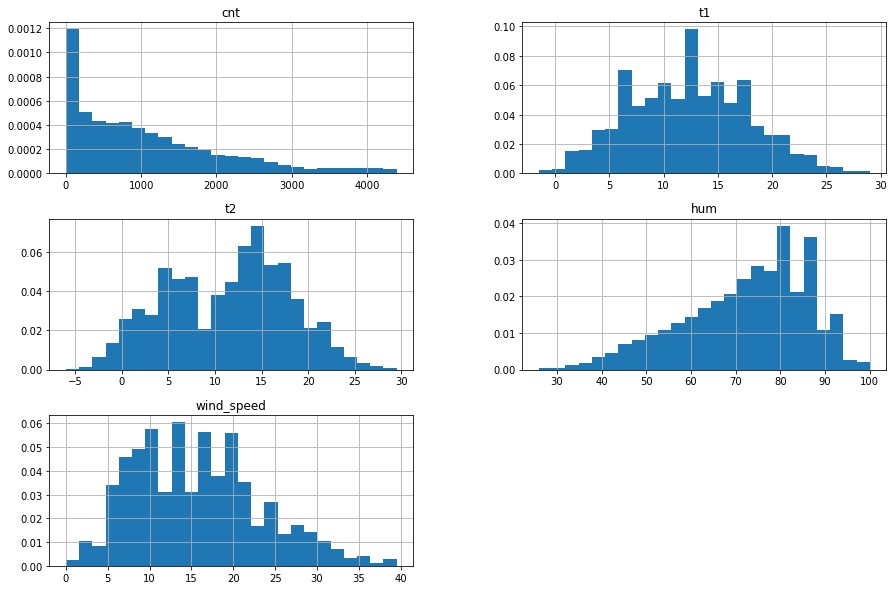

In [19]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df[cols].hist(ax=ax, density=True,bins=25)
# plt.show()
display(df.describe())
plt.savefig('figures/outliers_excluded_distr.png')


In [20]:
data.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,ts,time,date,month,year,season_str,day,hour
17409,3/1/2017 19:00,1042,5.0,1.0,81.0,19.0,0,0.0,3,2017-03-01 19:00:00,19:00,2017-03-01,3,2017,Winter,Wednesday,19
17410,3/1/2017 20:00,541,5.0,1.0,81.0,21.0,0,0.0,3,2017-03-01 20:00:00,20:00,2017-03-01,3,2017,Winter,Wednesday,20
17411,3/1/2017 21:00,337,5.5,1.5,78.5,24.0,0,0.0,3,2017-03-01 21:00:00,21:00,2017-03-01,3,2017,Winter,Wednesday,21
17412,3/1/2017 22:00,224,5.5,1.5,76.0,23.0,0,0.0,3,2017-03-01 22:00:00,22:00,2017-03-01,3,2017,Winter,Wednesday,22
17413,3/1/2017 23:00,139,5.0,1.0,76.0,22.0,0,0.0,3,2017-03-01 23:00:00,23:00,2017-03-01,3,2017,Winter,Wednesday,23


In [21]:
df[(df['year']==2015)&(df['season_str']=='Winter')].cnt.mean()

816.7532846715328

In [22]:
(len(data) - len(df))/len(data)

0.02423476712800781

In [23]:
outliers = pd.DataFrame()
for i in cols:
    outliers[i] = outliers_IQR(data,i)
outliers

,cnt,t1,t2,hum,wind_speed
count,672.000000,64.000000,19.000000,72.000000,236.000000
mean,4338.517857,30.507812,32.578947,40.409722,40.800847
std,448.760438,1.677328,0.803865,96.198311,3.763848
min,3796.000000,28.500000,31.500000,20.500000,36.500000
25%,4013.750000,29.000000,32.000000,27.000000,38.000000
50%,4266.000000,30.000000,32.500000,29.250000,40.000000
75%,4574.250000,32.000000,33.250000,32.000000,42.500000
max,7860.000000,34.000000,34.000000,845.000000,56.500000


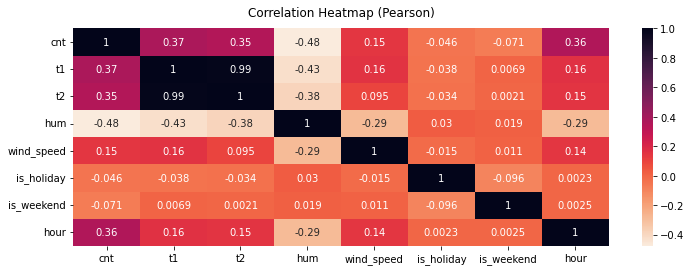

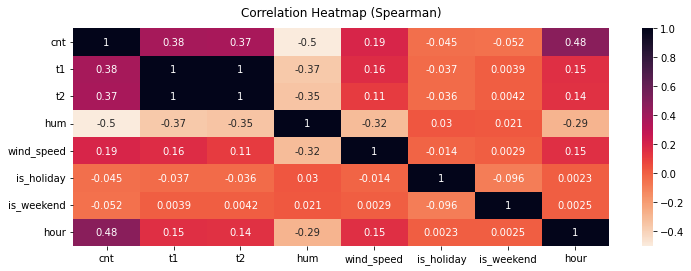

In [24]:
fig, ax = plt.subplots(figsize=(12,4)) 
heatmap = sns.heatmap(df.loc[:,~df.columns.isin(['year', 'month', 'season'])].corr(), annot=True,cmap = 'rocket_r')# vmin=-1, vmax=1,
heatmap.set_title('Correlation Heatmap (Pearson)', fontdict={'fontsize':12}, pad=12)
plt.savefig('figures/corr_pearson.png',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(12,4)) 
heatmap = sns.heatmap(df.loc[:,~df.columns.isin(['year', 'month', 'season'])].corr(method='spearman'), annot=True,cmap = 'rocket_r')# vmin=-1, vmax=1,
heatmap.set_title('Correlation Heatmap (Spearman)', fontdict={'fontsize':12}, pad=12)
plt.savefig('figures/corr_spearman.png',bbox_inches='tight')
plt.show()

# spearman vs pearson - linear vs non-linear releationship - I can use linear models 

In [25]:
display(compute_vif(df, ['t1', 't2', 'hum', 'wind_speed', 'is_holiday','season', 'is_weekend', 'hour']))#
display(compute_vif(df, ['t2', 'hum', 'wind_speed', 'is_holiday','season', 'is_weekend', 'hour']))#

/var/folders/3h/djzfk7rx2lz1dhv708z72klr0000gn/T/ipykernel_91358/3449070431.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,t1,55.760421
1,t2,53.466739
2,hum,1.521018
3,wind_speed,1.253448
4,is_holiday,1.013638
5,season,1.164027
6,is_weekend,1.011752
7,hour,1.109673


/var/folders/3h/djzfk7rx2lz1dhv708z72klr0000gn/T/ipykernel_91358/3449070431.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,t2,1.229894
1,hum,1.425091
2,wind_speed,1.108241
3,is_holiday,1.013362
4,season,1.163940
5,is_weekend,1.010434
6,hour,1.109672


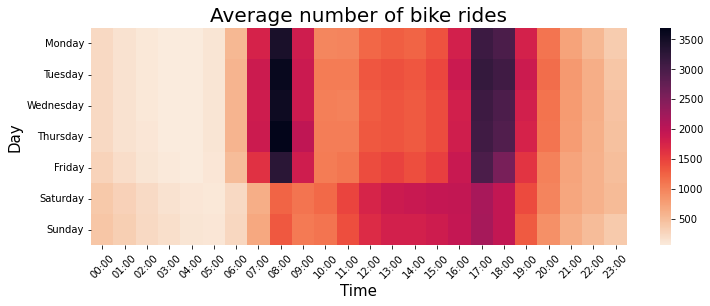

In [26]:
hm = data.groupby(by=['day', 'time'])['cnt'].mean().reset_index().pivot(index="day", columns='time', values='cnt')
hm.index = pd.CategoricalIndex(hm.index, categories= day_names)
hm.sort_index(level=0, inplace=True)
fig, ax = plt.subplots(figsize=(12,4)) 
sns.heatmap(hm, cmap = 'rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Average number of bike rides', fontsize = 20)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Day', fontsize = 15)
plt.savefig('figures/heatmap_per_day.png',bbox_inches='tight')
plt.show()

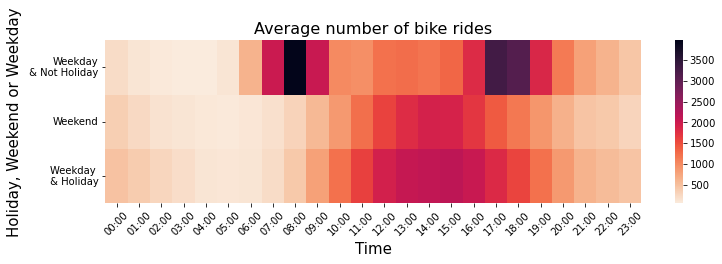

In [27]:
hm = data.groupby(by=['time','is_weekend','is_holiday'])['cnt'].mean().reset_index().pivot(index=['is_weekend','is_holiday'], columns='time', values='cnt')
# hm.index = pd.CategoricalIndex(hm.index, categories= day_names)
hm.sort_index(level=0, inplace=True)
fig, ax = plt.subplots(figsize=(12,3)) 
sns.heatmap(hm, cmap = 'rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(['Weekday\n & Not Holiday','Weekend','Weekday \n & Holiday'], rotation=0)

plt.title('Average number of bike rides', fontsize = 16)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Holiday, Weekend or Weekday', fontsize = 15)
plt.savefig('figures/heatmap_per_weekday_hol.png',bbox_inches='tight')

plt.show()

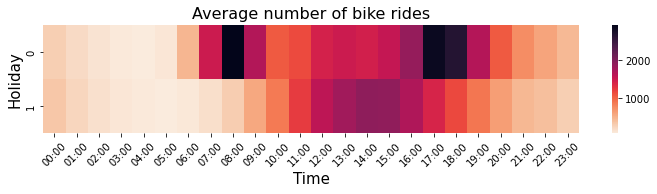

In [28]:
hm = data.groupby(by=['is_holiday','time'])['cnt'].mean().reset_index().pivot(index="is_holiday", columns='time', values='cnt')
# hm.index = pd.CategoricalIndex(hm.index, categories= day_names)
hm.sort_index(level=0, inplace=True)
fig, ax = plt.subplots(figsize=(12,2)) 
sns.heatmap(hm, cmap = 'rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Average number of bike rides', fontsize = 16)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Holiday', fontsize = 15)
plt.savefig('figures/heatmap_per_holiday.png',bbox_inches='tight')
plt.show()

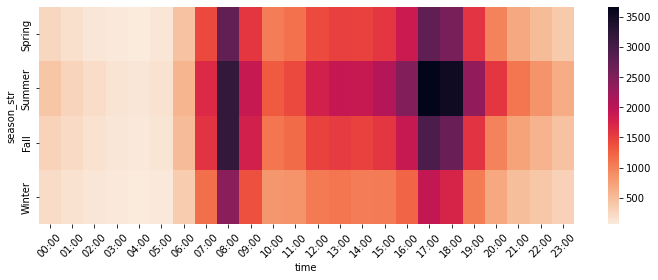

In [29]:
hm = data.groupby(by=['season_str', 'time'])['cnt'].mean().reset_index().pivot(index="season_str", columns='time', values='cnt')
hm.index = pd.CategoricalIndex(hm.index, categories= ['Spring', 'Summer', 'Fall', 'Winter'])
hm.sort_index(level=0, inplace=True)
fig, ax = plt.subplots(figsize=(12,4)) 
sns.heatmap(hm, cmap = 'rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

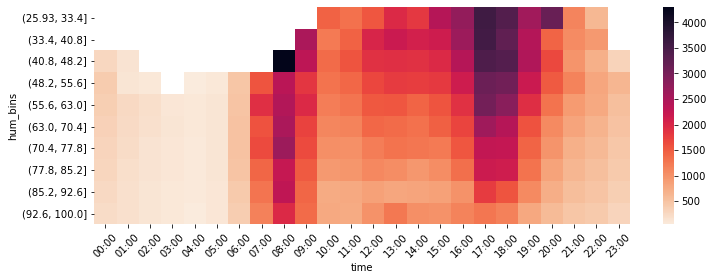

In [30]:
hm = df.groupby(by=['hum_bins', 'time'])['cnt'].mean().reset_index().pivot(index="hum_bins", columns='time', values='cnt')
# hm.index = pd.CategoricalIndex(hm.index, categories= ['Spring', 'Summer', 'Fall', 'Winter'])
hm.sort_index(level=0, inplace=True)
fig, ax = plt.subplots(figsize=(12,4)) 
sns.heatmap(hm, cmap = 'rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

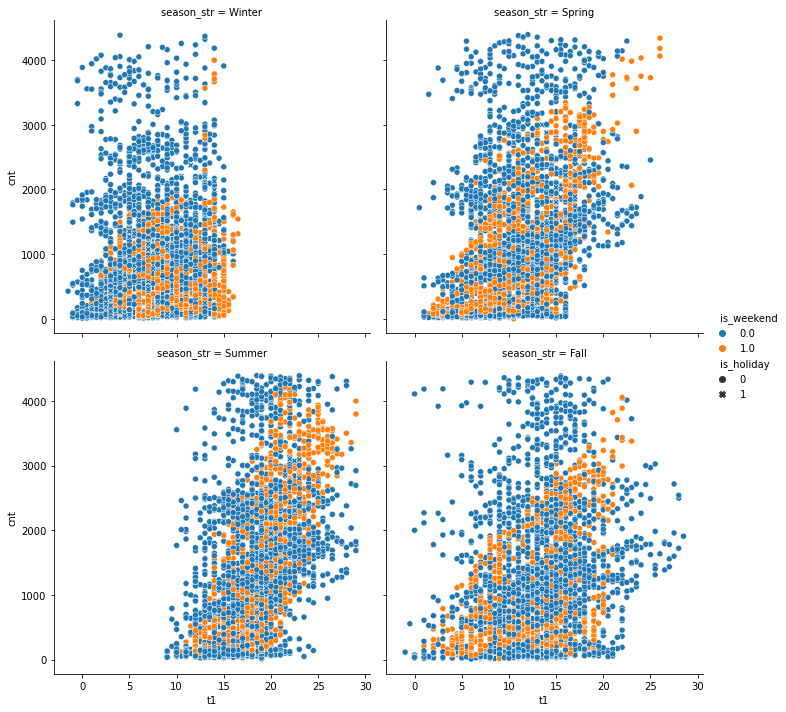

In [31]:
f = sns.relplot(
    data=df, x="t1", y="cnt",
    col="season_str", hue="is_weekend", style="is_holiday",
    kind="scatter", col_wrap=2
)

In [32]:
time_list = df.time.unique()
time_list.sort()

/var/folders/3h/djzfk7rx2lz1dhv708z72klr0000gn/T/ipykernel_91358/1229416886.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(time_list, rotation=45)


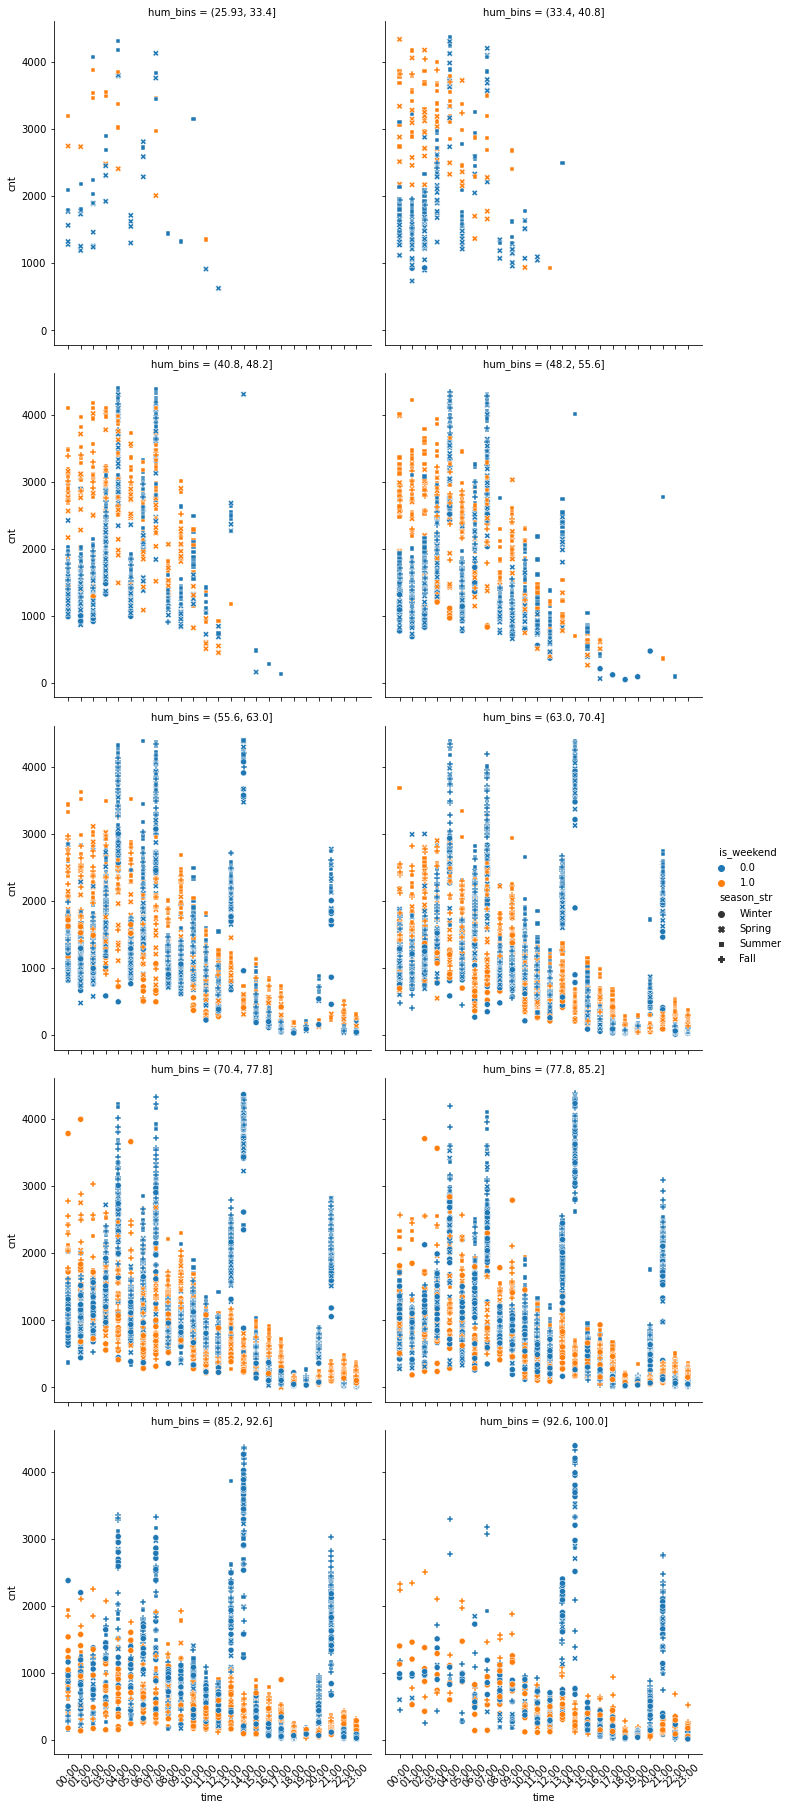

In [33]:
plot = sns.relplot(
    data=df, x="time", y="cnt",
    col="hum_bins", hue="is_weekend", style="season_str",
    kind="scatter", col_wrap=2
)

for axes in plot.axes.flat:
    _ = axes.set_xticklabels(time_list, rotation=45)
# plt.tight_layout()

# g.xticks(rotation=90)

/var/folders/3h/djzfk7rx2lz1dhv708z72klr0000gn/T/ipykernel_91358/2571469907.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(time_list, rotation=45)


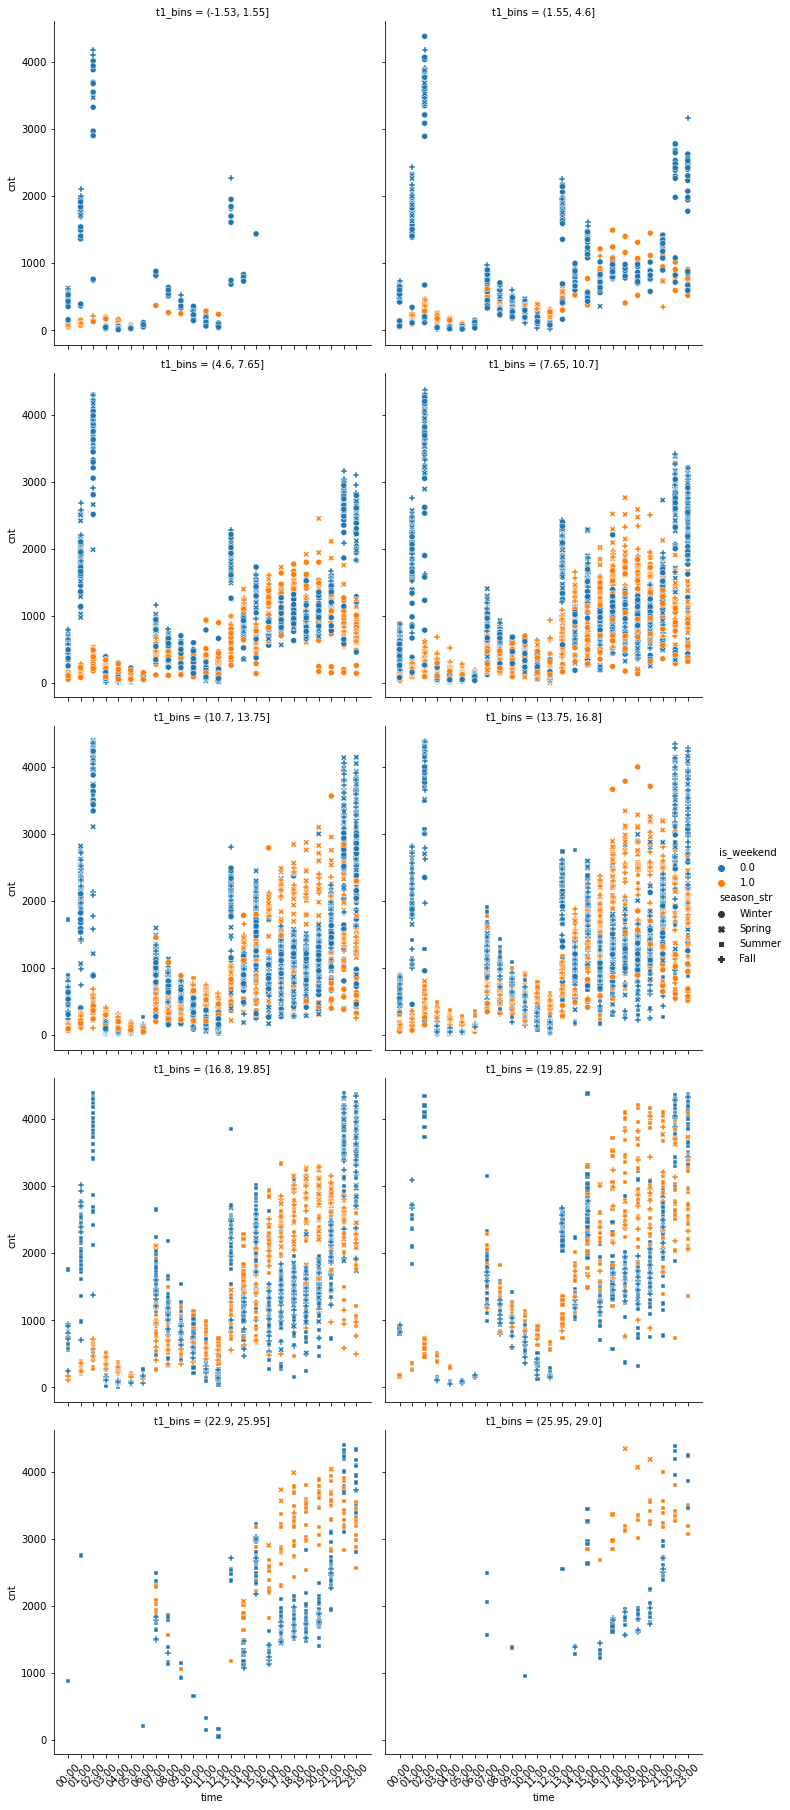

In [34]:
plot = sns.relplot(
    data=df, x="time", y="cnt",
    col="t1_bins", hue="is_weekend", style="season_str",
    kind="scatter", col_wrap=2
)

for axes in plot.axes.flat:
    _ = axes.set_xticklabels(time_list, rotation=45)
# plt.tight_layout()

# g.xticks(rotation=90)

In [35]:
(df['t2'] - df['t1']).describe()

count    16991.000000
mean        -0.957154
std          1.395724
min         -6.000000
25%         -2.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

In [36]:
data[(data['is_weekend']==1) & (data['is_holiday']==1)] # holidays are never weekends.. 

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,season,ts,time,date,month,year,season_str,day,hour


<AxesSubplot:xlabel='t2', ylabel='cnt'>

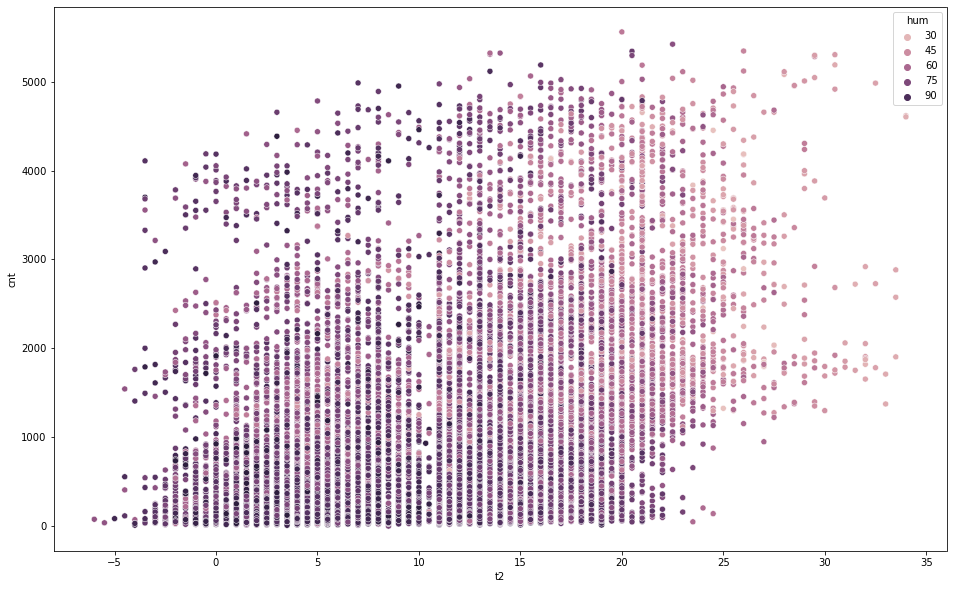

In [37]:
fig, ax = plt.subplots(figsize=(16,10)) 
sns.scatterplot(data=data[(data['hum']<800)&(data['cnt']<6000)], x="t2", y="cnt", hue="hum")#, style='is_weekend')


<AxesSubplot:xlabel='t1', ylabel='cnt'>

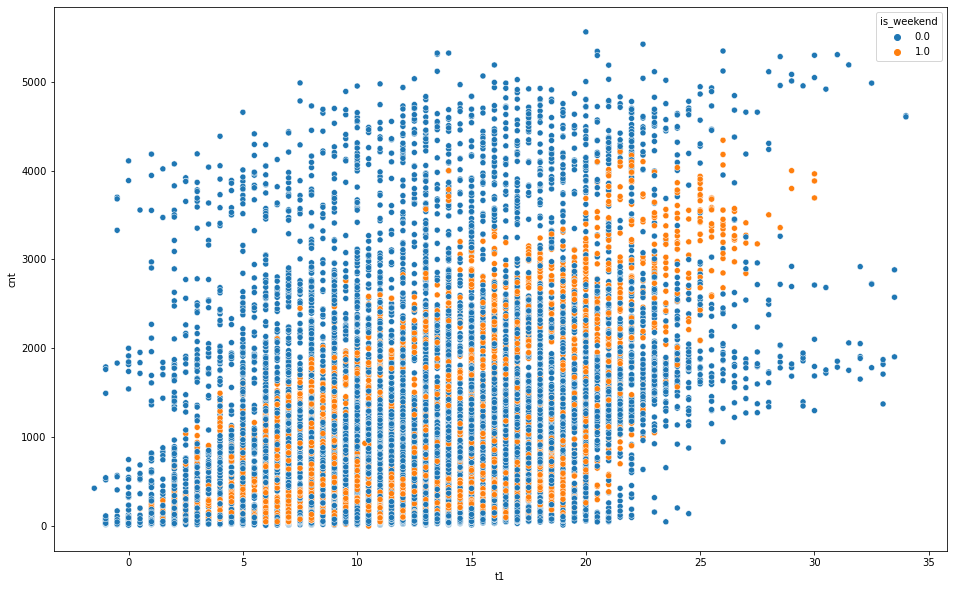

In [38]:
fig, ax = plt.subplots(figsize=(16,10)) 
sns.scatterplot(data=data[(data['hum']<800)&(data['cnt']<6000)], x="t1", y="cnt", hue="is_weekend")#, style='is_weekend')


# Prediction

In [39]:
# Random Forest
x_cols = ['t1', 't2', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season','hour']
X = data[data['year'] == 2015][x_cols]
y = data[data['year'] == 2015]['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


In [40]:
x_cols = ['t1', 't2', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season','hour']
X = data[data['year'] == 2015][x_cols]
y = data[data['year'] == 2015]['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(max_depth= None, min_samples_leaf= 1, min_samples_split= 5, 
                                 n_estimators= 150, random_state=42)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

print(mean_absolute_error(y_train, rf_model.predict(X_train)))
print(mean_squared_error(y_train, rf_model.predict(X_train)))

rf_mae = mean_absolute_error(y_test, predictions)
print("RF MAE:", round(rf_mae))
mse = mean_squared_error(y_test, predictions)
print("RF (GridSearchCV) MSE:", round(mse))

print(round(rf_model.score(X_train, y_train, sample_weight=None),3))
print(round(rf_model.score(X_test, y_test, sample_weight=None),3))

76.96392654355571
21366.08708843349
RF MAE: 152
RF (GridSearchCV) MSE: 75041
0.981
0.931


In [41]:
X_test = data[data['year']==2016][x_cols]
y_test = data[data['year']==2016]['cnt']
print(rf_model.score(X_test, y_test, sample_weight=None))
predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, predictions)
print("RF MAE:", rf_mae)
mse = mean_squared_error(y_test, predictions)
print("RF (GridSearchCV) MSE:", mse)

0.9225396596379298
RF MAE: 183.461927036229
RF (GridSearchCV) MSE: 94921.7864010106


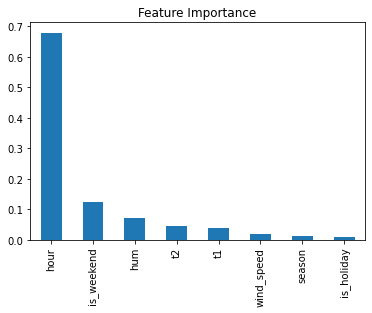

In [42]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.savefig('figures/RF_feature_importance.png',bbox_inches='tight')

In [43]:
# knn 
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [3, 5, 7,9,12],
    'p': [1, 2]  # Minkowski distance parameter
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
mae = mean_absolute_error(y_test, predictions)
print("KNN (GridSearchCV) MAE:", mae)

mse = mean_squared_error(y_test, predictions)
print("KNN (GridSearchCV) MSE:", mse)

# mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Best Hyperparameters: {'n_neighbors': 7, 'p': 1}
KNN (GridSearchCV) MAE: 485.71891678846504
KNN (GridSearchCV) MSE: 564438.0565629172
Mean Squared Error: 564438.0565629172
R-squared Score: 0.5393937932229702


In [44]:
help(best_model.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.neighbors._regression.KNeighborsRegressor instance
    Return the coefficient of determination :math:`R^2` of the
    prediction.
    
    The coefficient :math:`R^2` is defined as :math:`(1 - \frac{u}{v})`,
    where :math:`u` is the residual sum of squares ``((y_true - y_pred)
    ** 2).sum()`` and :math:`v` is the total sum of squares ``((y_true -
    y_true.mean()) ** 2).sum()``. The best possible score is 1.0 and it
    can be negative (because the model can be arbitrarily worse). A
    constant model that always predicts the expected value of `y`,
    disregarding the input features, would get a :math:`R^2` score of
    0.0.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples. For some estimators this may be a precomputed
        kernel matrix or a list of generic objects instead with shape
        ``(n_samples, n_samples_fitted)`